## Jupyteer Notebook tho accompany the paper:

## **A global apparent polar wander path for the last 320 Ma calculated from site-level paleomagnetic data**

#### **by B. Vaes, D.J.J. van Hinsbergen, S.H.A. van de Lagemaat, E. van der Wiel, N. Lom, E.L. Advokaat, L.M. Boschman, L. C. Gall, A. Greve, C. Guilmette, S. Li, P.C. Lippert, L. Montheil, A. Qayyum & C.G. Langreis**

#### This manuscript was published in *Earth-Science Reviews* in 2023 as:

#### Vaes, B., van Hinsbergen, D. J., van de Lagemaat, S. H., van der Wiel, E., Lom, N., Advokaat, E. L., ... & Langereis, C. G. (2023). A global apparent polar wander path for the last 320 Ma calculated from site-level paleomagnetic data. Earth-Science Reviews, 104547. https://doi.org/10.1016/j.earscirev.2023.104547

# Install and import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import time
from statistics import mean,median
from pmagpy import pmag,ipmag,pmagplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import sys
import math

# CHECK CARTOPY
has_cartopy, cartopy = pmag.import_cartopy()

if has_cartopy == True:
  print('Cartopy installed')
  import cartopy.crs as ccrs
  import cartopy.feature as cfeature

# IMPORT ADDITIONAL FUNCTIONS
from APWP_functions import boot_ref_pole,boot_APWP,running_mean_APWP,get_pseudo_vgps,rotate_with_ep,get_rotated_vgps,sedimentary_pole_resample,get_resampled_sed_poles

Cartopy installed


Mounting Google Drive locally, insert the directory and import auxiliar.py

# Load input data

In [ ]:
# ------------------------
# READ DATA FROM DATABASE
# ------------------------

fn='Table_S2.xlsx'   # read database Excel file
fn_no = 'Table_S2_no.xlsx'  # read database Excel file without North America
df=pd.read_excel(fn,skiprows=2,header=0)     # store data in Pandas dataframe
df_no=pd.read_excel(fn_no,skiprows=2,header=0)     # store data in Pandas dataframe

# --------
# FILTER DATAFRAME
df = df[(df.excl == 0) & (df.Deenen != False) & (df.max_age - df.min_age <= 20.)] # select poles that are not excluded
df = df.reset_index(drop=True,inplace=False) # reset index of dataframe

df_no = df_no[(df_no.excl == 0) & (df_no.Deenen != False) & (df_no.max_age - df_no.min_age <= 20.)] # select poles that are not excluded
df_no = df_no.reset_index(drop=True,inplace=False) # reset index of dataframe

# if K and A95 are unavailable, replace with estimated value from Cox (1970) formula
df.K.fillna(df.K_est, inplace=True)
df.A95.fillna(df.A95_est, inplace=True)

df_no.K.fillna(df_no.K_est, inplace=True)
df_no.A95.fillna(df_no.A95_est, inplace=True)

# OPTIONAL:
# Use maximum of N = 50 per database entry
#df.loc[(df.N > 50),'N'] = 50

# if age uncertainties are not given, use ±2 Ma 
df.min_age.fillna((df.age-2.), inplace=True)
df.max_age.fillna((df.age+2.), inplace=True)

df_no.min_age.fillna((df_no.age-2.), inplace=True)
df_no.max_age.fillna((df_no.age+2.), inplace=True)

# print rows where N or K are not provided
nan_Ns = df[df['N'].isnull()]
if len(nan_Ns) > 0:
  print('WARNING: SEVERAL ENTRIES DO NOT HAVE A SPECIFIED N')
  print(nan_Ns)
nan_Ks = df[df['K'].isnull()]
if len(nan_Ks) > 0:
  print('WARNING: SEVERAL ENTRIES DO NOT HAVE A SPECIFIED K')
  print(nan_Ks)
  
df.N.fillna(20,inplace=True)
df = df.astype({'N':'int'}) # ensure values for N are integers

nan_Ns_no = df_no[df_no['N'].isnull()]
if len(nan_Ns_no) > 0:
  print('WARNING: SEVERAL ENTRIES DO NOT HAVE A SPECIFIED N')
  print(nan_Ns_no)
nan_Ks_no = df_no[df_no['K'].isnull()]
if len(nan_Ks_no) > 0:
  print('WARNING: SEVERAL ENTRIES DO NOT HAVE A SPECIFIED K')
  print(nan_Ks_no)
df_no.N.fillna(20,inplace=True)
df_no = df_no.astype({'N':'int'}) # ensure values for N are integers

# print dataframe head and number of entries
print(df)
print('NUMBER OF ENTRIES = ',len(df)) 

# --------
# IMPORT GAPWAP DATA
gapwap_file = 'T12_gapwap.xlsx'   # define name Excel file with GAPWaP of Torsvik et al. (2012)
gapwap_df = pd.read_excel(gapwap_file,skiprows=None,header=0,usecols='A:E')   # read Excel file
#print(gapwap_df.head())

# IMPORT REFERENCE GAPWAP
ref_gapwap_file = 'ref_APWP.xlsx'   # define name Excel file with new global APWP
ref_gapwap_df = pd.read_excel(ref_gapwap_file,skiprows=None,header=0,usecols='A:N')   # read Excel file
#print(ref_gapwap_df)

                                 name  min_age  max_age       age   slat  \
0                           Roperch15    0.000    0.005    0.0025 -38.91   
1                          Dichiara14    0.002    0.008    0.0050  38.59   
2                            Kissel15    0.000    0.015    0.0075  28.18   
3                             Salis89    0.008    0.012    0.0100  45.52   
4                            Tanaka09    0.000    0.021    0.0105 -38.16   
..                                ...      ...      ...       ...    ...   
345           Mafra Formation, Brazil  298.900  307.000  303.0000 -26.14   
346  Moscovian, Murzuq basin, Algeria  307.000  315.200  311.1000  23.55   
347        Tashkovska Donbas, Ukraine  315.200  323.400  319.3000  48.78   
348         Newcastle range volcanics  315.600  328.200  321.9000 -18.39   
349                    Magdalen Basin  315.200  330.300  322.7500  46.20   

        slon    N   mDec  mInc      k  ...     f  p_std  Deenen  excl  \
0    288.260  

# Store Euler poles of plate circuit

In [3]:
# LOAD CSV FILE WITH EULER POLES
EP_data = np.genfromtxt('Euler_poles_plate_circuit.csv',skip_header=1,delimiter=',')
print(EP_data)
# plate_IDs = np.unique(EP_data[:,0])
# print(plate_IDs)

[[ 1.010000000e+02  0.000000000e+00  0.000000000e+00  0.000000000e+00
   0.000000000e+00]
 [ 1.010000000e+02  1.000000000e+00  7.902335131e+01  3.199215923e+01
   2.321030840e-01]
 [ 1.010000000e+02  2.000000000e+00  7.911677253e+01  3.454332781e+01
   4.566432390e-01]
 ...
 [ 2.007000000e+03  3.600000000e+01  4.204559903e+01 -4.145710967e+01
   9.431770978e+00]
 [ 2.007000000e+03  3.700000000e+01  4.210881646e+01 -4.088210228e+01
   9.777669327e+00]
 [ 2.007000000e+03  3.800000000e+01  4.216452724e+01 -4.033754277e+01
   1.012388416e+01]]


# Compute global APWP from simulated site-level data with age weighting

In [4]:
# SELECT TIME INTERVAL
df_range = df[(df.age >= 60) & (df.age < 110)].copy()
df_range_no = df_no[(df_no.age >= 60) & (df_no.age < 110)].copy()
#df_range = df[df.age<250]
df_range = df_range.reset_index()
df_range_no = df_range_no.reset_index()
    
# PRINT MEAN AND MEDIAN OF KEY PARAMETERS
print('Number of VGPs per paleopole: mean = %2.1f, median = %2.1f' % (df_range['N'].mean(),df_range['N'].median()))
print('Fisher precision parameter (K): mean = %2.1f, median = %2.1f' % (df_range['K'].mean(),df_range['K'].median()))
print('Total number of VGPs =',df_range['N'].sum())


df_APWP = pd.DataFrame(columns=['age','run','N','A95','plon','plat','kappa','csd','mean_age'])
df_APWP_no = pd.DataFrame(columns=['age','run','N','A95','plon','plat','kappa','csd','mean_age'])

window_length = 20
time_step = 5
min_age,max_age = 60, 110
Nb = 10

Number of VGPs per paleopole: mean = 23.7, median = 16.0
Fisher precision parameter (K): mean = 34.3, median = 31.6
Total number of VGPs = 1349


In [24]:
# COMPUTE REFERENCE POLES FOR EACH TIME STEP
# Nb IS NUMBER OF ITERATIONS

start_time = time.time() # start timer

for i in range(Nb):
  # RE-SAMPLE SEDIMENTARY POLES
  #print(df_range.plat)
  df_iter = get_resampled_sed_poles(df_range)
  df_iter_no = get_resampled_sed_poles(df_range_no)
  #print(df_iter.plat)
    
  # GET PSEUDO VGPS
  pseudo_vgps = get_pseudo_vgps(df_iter['plon'].values,df_iter['plat'].values,df_iter['K'].values,df_iter['N'].values,df_iter['plateID'].values,df_iter['age'].values,df_iter['min_age'].values,df_iter['max_age'].values)
  pseudo_vgps_no = get_pseudo_vgps(df_iter_no['plon'].values,df_iter_no['plat'].values,df_iter_no['K'].values,df_iter_no['N'].values,df_iter_no['plateID'].values,df_iter_no['age'].values,df_iter_no['min_age'].values,df_iter_no['max_age'].values)
  # ROTATE VGPs
  rVGPs = get_rotated_vgps(pseudo_vgps['plon'].values,pseudo_vgps['plat'].values,pseudo_vgps['age'].values,pseudo_vgps['plate_id'].values,EP_data,output_type='rvgps')
  df_rvgps = pd.DataFrame(rVGPs, columns = ['rlon', 'rlat'])

  rVGPs_no = get_rotated_vgps(pseudo_vgps_no['plon'].values,pseudo_vgps_no['plat'].values,pseudo_vgps_no['age'].values,pseudo_vgps_no['plate_id'].values,EP_data,output_type='rvgps')
  df_rvgps_no = pd.DataFrame(rVGPs_no, columns = ['rlon', 'rlat'])

  # combines dataframe
  df_vgps = pd.concat([pseudo_vgps,df_rvgps],axis=1)
  df_vgps_no = pd.concat([pseudo_vgps_no,df_rvgps_no],axis=1)

  # compute single iteration of bootstrap APWP
  APWP_iter = running_mean_APWP(df_vgps, 'rlon', 'rlat', 'age', window_length, time_step, max_age, min_age, elong=True)
  APWP_iter_no = running_mean_APWP(df_vgps_no, 'rlon', 'rlat', 'age', window_length, time_step, max_age, min_age, elong=True)
  #print(APWP_iter)

  APWP_iter['run'] = i
  df_APWP = pd.concat([df_APWP, APWP_iter], ignore_index=True)

  APWP_iter_no['run'] = i
  df_APWP_no = pd.concat([df_APWP_no, APWP_iter_no], ignore_index=True)
  if i % 10 == 0:
    print('iteration', i)

#print(df_APWP)
#print(df_APWP_no)
print("--- %s seconds ---" % (time.time() - start_time))

iteration 0
--- 1.2307589054107666 seconds ---


The previous but as a function

In [222]:
def compute_bootstrap_apwp(df_range, df_range_no, EP_data,
                           window_length=20, time_step=10,
                           min_age=60, max_age=100, Nb=10):
    """
    Run Nb bootstrap iterations and return concatenated APWP DataFrames
    (with and without North America).
    """
    start_time = time.time()
    df_APWP = pd.DataFrame(columns=['age','run','N','A95','plon','plat','kappa','csd','mean_age'])
    df_APWP_no = pd.DataFrame(columns=df_APWP.columns)

    for i in range(Nb):
        # re-sample sedimentary poles
        df_iter = get_resampled_sed_poles(df_range)
        df_iter_no = get_resampled_sed_poles(df_range_no)

        # get pseudo VGPs
        pseudo_vgps = get_pseudo_vgps(df_iter['plon'].values, df_iter['plat'].values,
                                      df_iter['K'].values, df_iter['N'].values,
                                      df_iter['plateID'].values, df_iter['age'].values,
                                      df_iter['min_age'].values, df_iter['max_age'].values)

        pseudo_vgps_no = get_pseudo_vgps(df_iter_no['plon'].values, df_iter_no['plat'].values,
                                         df_iter_no['K'].values, df_iter_no['N'].values,
                                         df_iter_no['plateID'].values, df_iter_no['age'].values,
                                         df_iter_no['min_age'].values, df_iter_no['max_age'].values)

        # rotate VGPs
        rVGPs = get_rotated_vgps(pseudo_vgps['plon'].values, pseudo_vgps['plat'].values,
                                 pseudo_vgps['age'].values, pseudo_vgps['plate_id'].values,
                                 EP_data, output_type='rvgps')
        df_rvgps = pd.DataFrame(rVGPs, columns=['rlon','rlat'])

        rVGPs_no = get_rotated_vgps(pseudo_vgps_no['plon'].values, pseudo_vgps_no['plat'].values,
                                    pseudo_vgps_no['age'].values, pseudo_vgps_no['plate_id'].values,
                                    EP_data, output_type='rvgps')
        df_rvgps_no = pd.DataFrame(rVGPs_no, columns=['rlon','rlat'])

        # combine and compute running-mean APWP for this iteration
        df_vgps = pd.concat([pseudo_vgps, df_rvgps], axis=1)
        df_vgps_no = pd.concat([pseudo_vgps_no, df_rvgps_no], axis=1)

        APWP_iter = running_mean_APWP(df_vgps, 'rlon', 'rlat', 'age',
                                      window_length, time_step, max_age, min_age, elong=True)
        if APWP_iter.empty:
            continue
        APWP_iter_no = running_mean_APWP(df_vgps_no, 'rlon', 'rlat', 'age',
                                         window_length, time_step, max_age, min_age, elong=True)
        if APWP_iter_no.empty:
            continue

        APWP_iter['run'] = i
        APWP_iter_no['run'] = i

        # append using concat (avoid deprecated .append)
        df_APWP = pd.concat([df_APWP, APWP_iter], ignore_index=True)
        df_APWP_no = pd.concat([df_APWP_no, APWP_iter_no], ignore_index=True)

    return df_APWP, df_APWP_no

In [116]:

df_APWP, df_APWP_no = compute_bootstrap_apwp(df_range, df_range_no, EP_data,
                                             window_length=window_length,
                                             time_step=time_step,
                                             min_age=min_age, max_age=max_age,
                                             Nb=Nb)

### Construct APWP with statistical parameters

In [117]:
bootstrap=True

mean_pole_ages = np.arange(min_age, max_age + time_step, time_step)

APWP = pd.DataFrame(columns=['age','N','V95','plon','plat','mean_K','mean_csd','mean_E','elong','mean_age'])
APWP_no = pd.DataFrame(columns=['age','N','V95','plon','plat','mean_K','mean_csd','mean_E','elong','mean_age'])

#print(df_APWP)
    
for age in mean_pole_ages:
    ref_poles = df_APWP.loc[df_APWP['age'] == age]
    ref_plons,ref_plats = ref_poles['plon'].tolist(),ref_poles['plat'].tolist()

    ref_poles_no = df_APWP_no.loc[df_APWP_no['age'] == age]
    ref_plons_no,ref_plats_no = ref_poles_no['plon'].tolist(),ref_poles_no['plat'].tolist()

    mean = ipmag.fisher_mean(dec=ref_plons, inc=ref_plats)
    mean_no = ipmag.fisher_mean(dec=ref_plons_no, inc=ref_plats_no)

    if mean:
        # Compute angular distances of pseudopoles to reference pole
        D_ppoles=[]
        for j in range(Nb):
            ang_distance = pmag.angle([ref_plons[j],ref_plats[j]],[mean['dec'], mean['inc']])
            D_ppoles.append(ang_distance[0])

        # Compute statistical parameters
        D_ppoles.sort()
        ind_95perc=int(0.95*Nb)
        V95 = D_ppoles[ind_95perc]

        # Compute mean of number of VGPs and K
        mean_N_VGPs = ref_poles['N'].mean()
        mean_K_VGPs = ref_poles['kappa'].mean()
        mean_csd_VGPs = ref_poles['csd'].mean()
        mean_E_VGPs = ref_poles['E'].mean()
        mean_age = ref_poles['mean_age'].mean()
        
        # Compute elongation of reference poles
        refpole_block = ipmag.make_di_block(ref_plons,ref_plats,unit_vector=False)
        ppars = pmag.doprinc(refpole_block)
        E = ppars["tau2"] / ppars["tau3"]

        # Add reference pole and metadata to dataframe
        APWP.loc[age] = [age, mean_N_VGPs, V95, mean['dec'], mean['inc'],mean_K_VGPs,mean_csd_VGPs,mean_E_VGPs,E,mean_age]

        # Repeat for dataset without North America
        D_ppoles_no=[]
        for j in range(Nb):
            ang_distance_no = pmag.angle([ref_plons_no[j],ref_plats_no[j]],[mean_no['dec'], mean_no['inc']])
            D_ppoles_no.append(ang_distance_no[0])

        D_ppoles_no.sort()
        ind_95perc_no=int(0.95*Nb)
        V95_no = D_ppoles_no[ind_95perc_no]

        mean_N_VGPs_no = ref_poles_no['N'].mean()
        mean_K_VGPs_no = ref_poles_no['kappa'].mean()
        mean_csd_VGPs_no = ref_poles_no['csd'].mean()
        mean_E_VGPs_no = ref_poles_no['E'].mean()
        mean_age_no = ref_poles_no['mean_age'].mean()

        refpole_block_no = ipmag.make_di_block(ref_plons_no,ref_plats_no,unit_vector=False)
        ppars_no = pmag.doprinc(refpole_block_no)
        E = ppars_no["tau2"] / ppars_no["tau3"]
        
        APWP_no.loc[age] = [age, mean_N_VGPs_no, V95_no, mean_no['dec'], mean_no['inc'],mean_K_VGPs_no,mean_csd_VGPs_no,mean_E_VGPs_no,E,mean_age_no]



APWP.reset_index(drop=1, inplace=True)
APWP_no.reset_index(drop=1, inplace=True)


the previous cell as a function

In [125]:
def construct_apwp_stats(df_bootstrap, df_bootstrap_no, min_age, max_age, time_step=10, Nb=10):
    """
    Construct APWP DataFrames with statistical parameters from bootstrap outputs.

    Parameters
    - df_bootstrap: DataFrame produced by bootstrap iterations (columns must include 'age','plon','plat','N','kappa','csd','E','mean_age')
    - df_bootstrap_no: same as df_bootstrap but for dataset without North America
    - min_age, max_age, time_step: define mean pole ages (np.arange(min_age, max_age+time_step, time_step))
    - Nb: expected number of bootstrap runs (used to compute V95; function is robust if fewer entries are present)

    Returns
    - APWP, APWP_no: DataFrames with columns ['age','N','V95','plon','plat','mean_K','mean_csd','mean_E','elong','mean_age']
    """
    mean_pole_ages = np.arange(min_age, max_age + time_step, time_step)
    columns = ['age','N','V95','plon','plat','mean_K','mean_csd','mean_E','elong','mean_age']
    APWP = pd.DataFrame(columns=columns)
    APWP_no = pd.DataFrame(columns=columns)

    for age in mean_pole_ages:
        ref_poles = df_bootstrap.loc[df_bootstrap['age'] == age]
        ref_plons = ref_poles['plon'].tolist()
        ref_plats = ref_poles['plat'].tolist()

        ref_poles_no = df_bootstrap_no.loc[df_bootstrap_no['age'] == age]
        ref_plons_no = ref_poles_no['plon'].tolist()
        ref_plats_no = ref_poles_no['plat'].tolist()

        # compute means (skip if no data)
        if len(ref_plons) == 0:
            continue

        mean = ipmag.fisher_mean(dec=ref_plons, inc=ref_plats)
        mean_no = None
        if len(ref_plons_no) > 0:
            mean_no = ipmag.fisher_mean(dec=ref_plons_no, inc=ref_plats_no)

        if mean:
            # angular distances to reference pole for full dataset
            D_ppoles = []
            for j in range(len(ref_plons)):
                ang_distance = pmag.angle([ref_plons[j], ref_plats[j]], [mean['dec'], mean['inc']])
                D_ppoles.append(ang_distance[0])
            D_ppoles.sort()
            n_ref = len(D_ppoles)
            ind_95 = int(0.95 * n_ref)
            ind_95 = min(max(ind_95, 0), n_ref - 1)
            V95 = D_ppoles[ind_95] if n_ref > 0 else np.nan

            mean_N_VGPs = ref_poles['N'].mean() if 'N' in ref_poles.columns else np.nan
            mean_K_VGPs = ref_poles['kappa'].mean() if 'kappa' in ref_poles.columns else np.nan
            mean_csd_VGPs = ref_poles['csd'].mean() if 'csd' in ref_poles.columns else np.nan
            mean_E_VGPs = ref_poles['E'].mean() if 'E' in ref_poles.columns else np.nan
            mean_age = ref_poles['mean_age'].mean() if 'mean_age' in ref_poles.columns else np.nan

            # compute elongation
            refpole_block = ipmag.make_di_block(ref_plons, ref_plats, unit_vector=False)
            ppars = pmag.doprinc(refpole_block)
            E = ppars.get("tau2", np.nan) / ppars.get("tau3", np.nan) if ppars.get("tau3") else np.nan

            APWP.loc[len(APWP)] = [age, mean_N_VGPs, V95, mean['dec'], mean['inc'],
                                   mean_K_VGPs, mean_csd_VGPs, mean_E_VGPs, E, mean_age]

            # repeat for dataset without North America if available
            if mean_no and len(ref_plons_no) > 0:
                D_ppoles_no = []
                for j in range(len(ref_plons_no)):
                    ang_distance_no = pmag.angle([ref_plons_no[j], ref_plats_no[j]], [mean_no['dec'], mean_no['inc']])
                    D_ppoles_no.append(ang_distance_no[0])
                D_ppoles_no.sort()
                n_ref_no = len(D_ppoles_no)
                ind_95_no = int(0.95 * n_ref_no)
                ind_95_no = min(max(ind_95_no, 0), n_ref_no - 1)
                V95_no = D_ppoles_no[ind_95_no] if n_ref_no > 0 else np.nan

                mean_N_VGPs_no = ref_poles_no['N'].mean() if 'N' in ref_poles_no.columns else np.nan
                mean_K_VGPs_no = ref_poles_no['kappa'].mean() if 'kappa' in ref_poles_no.columns else np.nan
                mean_csd_VGPs_no = ref_poles_no['csd'].mean() if 'csd' in ref_poles_no.columns else np.nan
                mean_E_VGPs_no = ref_poles_no['E'].mean() if 'E' in ref_poles_no.columns else np.nan
                mean_age_no = ref_poles_no['mean_age'].mean() if 'mean_age' in ref_poles_no.columns else np.nan

                refpole_block_no = ipmag.make_di_block(ref_plons_no, ref_plats_no, unit_vector=False)
                ppars_no = pmag.doprinc(refpole_block_no)
                E_no = ppars_no.get("tau2", np.nan) / ppars_no.get("tau3", np.nan) if ppars_no.get("tau3") else np.nan

                APWP_no.loc[len(APWP_no)] = [age, mean_N_VGPs_no, V95_no, mean_no['dec'], mean_no['inc'],
                                              mean_K_VGPs_no, mean_csd_VGPs_no, mean_E_VGPs_no, E_no, mean_age_no]

    APWP.reset_index(drop=True, inplace=True)
    APWP_no.reset_index(drop=True, inplace=True)
    return APWP, APWP_no

In [167]:
APWP, APWP_no = construct_apwp_stats(df_APWP, df_APWP_no, min_age, max_age, time_step=10, Nb=10)

## Plot global APWP (Fig. 5)

<Figure size 6000x4800 with 0 Axes>

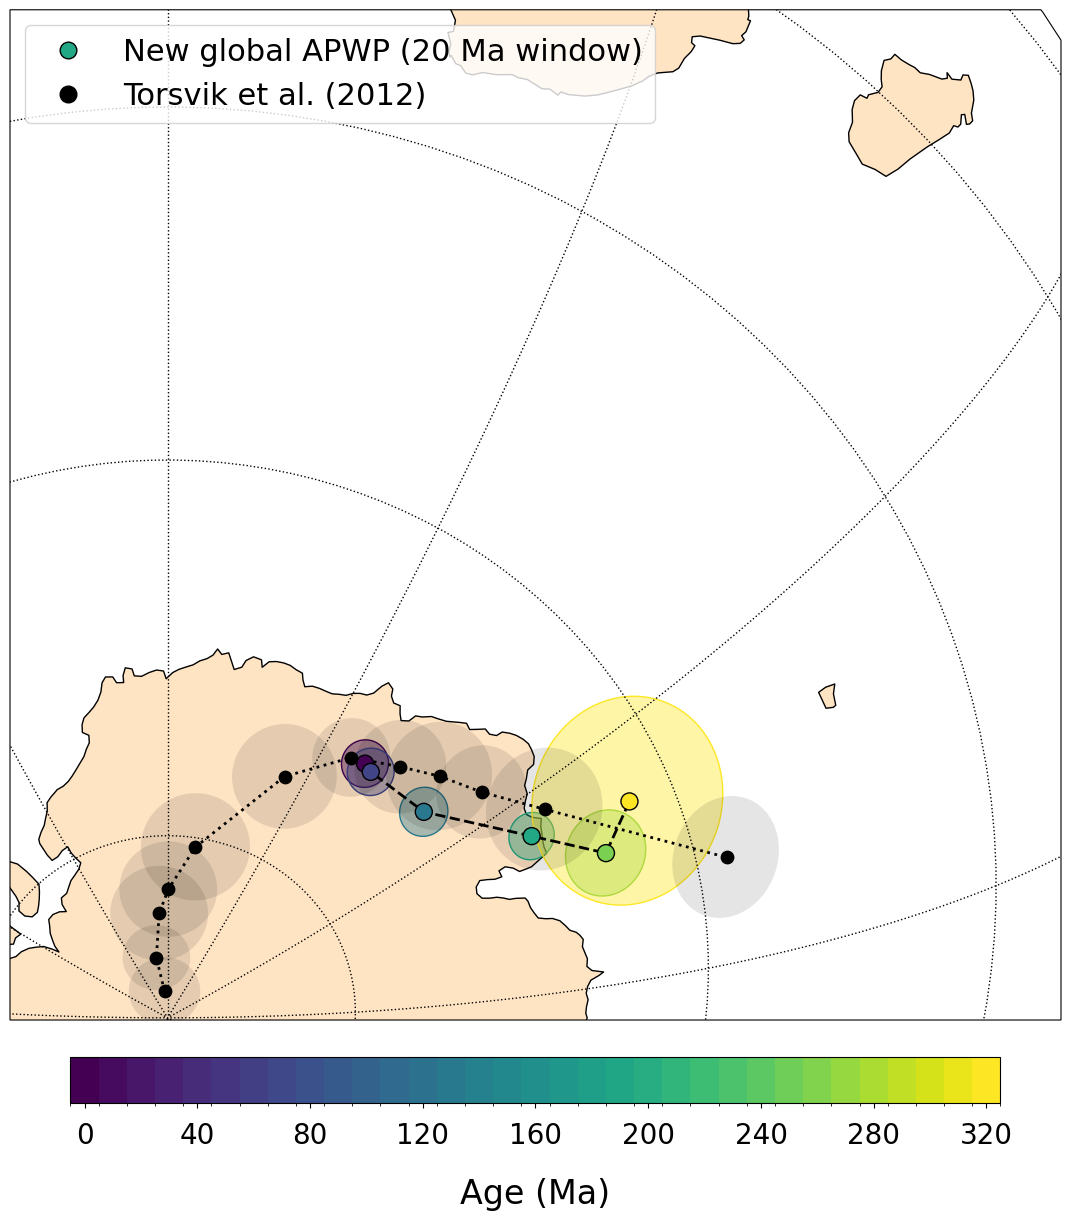

In [120]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# plot global APWP
plt.rcParams['axes.facecolor']='white'
cmap = plt.cm.viridis

map_axis = plt.figure(figsize=(20,16),facecolor='white',dpi=300)
map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-70,figsize=(20,16),land_color='bisque',lat_grid=[0,-20.,-40.,-60.,-80.,-90.])

# Change reference pole longitudes to negative values for plotting of arcs between successive reference poles
APWP.loc[APWP['plon'] > 180, 'plon'] = APWP['plon'] - 360
gapwap_df.loc[gapwap_df['lon'] > 180, 'lon'] = gapwap_df['lon'] - 360
ref_gapwap_df.loc[ref_gapwap_df['plon'] > 180, 'plon'] = ref_gapwap_df['plon'] - 360

# ------------
# PLOT NEW GLOBAL APWP
ipmag.plot_poles_colorbar(map_axis, APWP.plon, APWP.plat, APWP.V95, APWP.age, min_age, max_age, markersize=150,edgecolor='k',filled_pole=True,fill_alpha=0.4,outline=True,colorbar=False)
#ipmag.plot_poles(map_axis,APWP.plon,APWP.plat,APWP.V95,markersize=100,marker='o',filled_pole=True,color='k',outline=False,fill_alpha=0.15) # no colorbar
# plot connecting lines
plt.plot(APWP.plon, APWP.plat, transform=ccrs.Geodetic(), color = 'k', linestyle = '--', lw=2) # plot connecting lines
# ------------

# Plot reference global APWP
# Torsvik et al. (2012)
#ipmag.plot_poles(map_axis, gapwap_df.lon, gapwap_df.lat, gapwap_df.a95, filled_pole=True, markersize=40, fill_alpha=0.15, outline=False)
ipmag.plot_poles(map_axis, gapwap_df.loc[0:(max_age/10),'lon'], gapwap_df.loc[0:(max_age/10),'lat'], gapwap_df.loc[0:(max_age/10),'a95'], filled_pole=True, markersize=80, fill_alpha=0.1, outline=False, label='Torsvik et al. (2012)')
plt.plot(gapwap_df.loc[0:(max_age/10),'lon'], gapwap_df.loc[0:(max_age/10),'lat'], transform=ccrs.Geodetic(), color = 'k', linestyle = ':', lw=2) # Add lines connecting reference poles
# Stored reference APWP
# ipmag.plot_poles(map_axis, ref_gapwap_df.plon, ref_gapwap_df.plat, ref_gapwap_df.V95, color='white',filled_pole=True, markersize=80, fill_alpha=0.15, outline=False, label='Global APWP (20 Ma window)')
# plt.plot(ref_gapwap_df.plon, ref_gapwap_df.plat, transform=ccrs.Geodetic(), color = 'k', linestyle = ':', lw=2) # Add lines connecting reference poles
# ipmag.plot_poles_colorbar(map_axis, ref_gapwap_df.plon, ref_gapwap_df.plat, ref_gapwap_df.V95, ref_gapwap_df.age, min_age, max_age, markersize=150,edgecolor='k',filled_pole=True,fill_alpha=0.4,outline=True,colorbar=False)

# ------------
# Plot all simulated reference poles from df_APWP dataframe
# color_mapping = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_age, vmax=max_age))
# colors = color_mapping.to_rgba(df_APWP.age).tolist()
# ipmag.plot_vgp(map_axis,df_APWP.plon, df_APWP.plat,markersize=40,marker='o',color=colors,edge='k',alpha=0.9)

# # Plot rotated pseudo-VGPs
#ipmag.plot_vgp(map_axis,df_vgps.rlon,df_vgps.rlat,markersize=5,marker='o',color='k',edge=None,alpha=1)
# df_sel = df_vgps[(df_vgps.age >= 70) & (df_vgps.age < 90)].copy()
# print(len(df_sel))
# ipmag.plot_vgp(map_axis,df_sel.rlon,df_sel.rlat,markersize=80,marker='o',color=cmap(9/33),edge='k',alpha=0.5)

# Plot paleopoles contributing to time window
# w1, w2 = 230, 250 # choose low and high end of time window
# for k in range(len(df_range)):
#     t1,t2 = df_range['min_age'][k], df_range['max_age'][k]
#     if t1 < w2 and t2 >= w1:
#         if t1 > w1 and t2 < w2:
#             overlap = t2-t1
#         elif t1 > w1:
#             overlap = w2-t1
#         else:
#             overlap = t2-w1
#         #print(t1,t2,overlap,df_range['N'][k])
#         ipmag.plot_pole(map_axis,df_range['Rlon'][k],df_range['Rlat'][k],0,markersize=df_range['N'][k]*10*(overlap/(t2-t1)),color='white',edgecolor='k')
# -----------

# Add colorbar
# sm = plt.cm.ScalarMappable(
#             cmap='viridis', norm=plt.Normalize(vmin=min_age, vmax=max_age))
ticks = [0,40,80,120,160,200,240,280,320]
sm = plt.cm.ScalarMappable(
            cmap='viridis', norm=BoundaryNorm(range(-5,335,10),cmap.N))
sm.set_array([])                        
cb = plt.colorbar(sm, ax=map_axis,orientation = 'horizontal', ticks = ticks, shrink=0.6, pad=0.03) 
cb.set_label(label = 'Age (Ma)',size=24,labelpad=20)
cb.ax.set_xticklabels(ticks)
cb.ax.tick_params(labelsize=20,pad=10)

# -----------
# Configure legend
legend_elements = [Line2D([0], [0], marker='o', color='white',markerfacecolor=cmap(0.6), markeredgecolor='k', label='New global APWP (%1d Ma window)' % window_length,markersize=12),
                   Line2D([0], [0], marker='o', color='white',markerfacecolor='k', markeredgecolor='k', label='Torsvik et al. (2012)',markersize=12)]
# legend_elements = [Line2D([0], [0], marker='o', color='white',markerfacecolor='k', markeredgecolor='k', label='Global APWP (20 Ma window)',markersize=12),
#                  Line2D([0], [0], marker='o', color='white',markerfacecolor=cmap(0.6), markeredgecolor='k', label='Maximum N = 50',markersize=12)]
plt.legend(loc=2, fontsize = 22, handles = legend_elements)

# -----------
# Set map extent
map_axis.set_extent([-10,100,-90,-33])
# plt.tight_layout()
                                                            
# -----------
# SAVE AND PLOT
plt.savefig('apwp.png',facecolor='white',dpi=400)
plt.savefig('apwp.svg',bbox_inches='tight',facecolor='white',dpi=500)
plt.show()

# calculate the angle between global APWPs that use and don't use NAM data

In [23]:
def ang_dist(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    return np.degrees(np.arccos(np.sin(lat1)*np.sin(lat2) + np.cos(lat1)*np.cos(lat2)*np.cos(lon1 - lon2)))


df_APWP, df_APWP_no = compute_bootstrap_apwp(df_range, df_range_no, EP_data,
                                                 window_length=window_length,
                                                 time_step=time_step,
                                                 min_age=min_age, max_age=max_age,
                                                 Nb=Nb)
APWP, APWP_no = construct_apwp_stats(df_APWP, df_APWP_no, min_age, max_age, time_step=10, Nb=10)

merged = pd.merge(APWP, APWP_no, on='age', suffixes=('_full', '_no'))
merged['Pole_Diff_deg'] = ang_dist(
        merged['plat_full'], merged['plon_full'],
        merged['plat_no'], merged['plon_no'])

# Plot
plt.plot(merged['age'], merged['Pole_Diff_deg'], marker='o')
plt.gca().invert_xaxis()
plt.xlabel('Age (Ma)')
plt.ylabel('Angular difference (°)')
plt.title('Influence of North America on Global APWP')
plt.show()

NameError: name 'compute_bootstrap_apwp' is not defined

In [189]:
# --- controls ---B_outer = 500          # how many times to repeat the whole resampling pipeline
B_outer = 10          # how many times to repeat the whole resampling pipeline
Nb_inner = Nb          # keep your internal bootstrap param if your functions use it
ages = np.arange(min_age, max_age + time_step, time_step)  # expected age grid

# Pre-allocate a results matrix: rows = ages, cols = bootstrap replicates
age_to_idx = {age: i for i, age in enumerate(ages)}
diff_mat = np.full((len(ages), B_outer), np.nan)

rng = np.random.default_rng(42)  # set a seed for reproducibility (optional)

for b in range(B_outer):
    # If your functions accept a seed, pass one to make each outer iteration independent
    df_APWP, df_APWP_no = compute_bootstrap_apwp(
        df_range, df_range_no, EP_data,
        window_length=window_length,
        time_step=time_step,
        min_age=min_age, max_age=max_age,
        Nb=Nb_inner
    )

    APWP, APWP_no = construct_apwp_stats(
        df_APWP, df_APWP_no,
        min_age, max_age,
        time_step=time_step, Nb=Nb_inner
    )

    merged = pd.merge(APWP, APWP_no, on='age', suffixes=('_full', '_no'))

    # Compute angular differences for this replicate
    diffs = ang_dist(
        merged['plat_full'].to_numpy(), merged['plon_full'].to_numpy(),
        merged['plat_no'].to_numpy(),   merged['plon_no'].to_numpy()
    )

    # Store into the matrix by age index
    for age_val, d in zip(merged['age'].to_numpy(), diffs):
        if age_val in age_to_idx:
            diff_mat[age_to_idx[age_val], b] = d

# Convert to dataframe for convenience
diff_df = pd.DataFrame({
    'age': ages,
    'mean': np.nanmean(diff_mat, axis=1),
    'p025': np.nanpercentile(diff_mat, 2.5, axis=1),
    'p975': np.nanpercentile(diff_mat, 97.5, axis=1),
    'std':  np.nanstd(diff_mat, axis=1),
    'n_eff': np.sum(~np.isnan(diff_mat), axis=1)   # how many reps contributed per age
})

# Plot mean + 95% CI band
fig, ax = plt.subplots()
ax.plot(diff_df['age'], diff_df['mean'], marker='o', label='Mean Δ (°)')
ax.fill_between(diff_df['age'], diff_df['p025'], diff_df['p975'], alpha=0.25, label='95% CI')

ax.invert_xaxis()
ax.set_xlabel('Age (Ma)')
ax.set_ylabel('Angular difference (°)')
ax.set_title('Influence of North America on Global APWP (bootstrapped)')
ax.legend()
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

## Compute angular distances and APW rates

In [43]:
if time_step == 10:
  # Compute angular difference between RM APWP and published one
  N_refpoles = len(APWP)
  APWP_diff = []
  for i in range(N_refpoles):
    #pole_age = APWP['age'][i]
    pole_age = ref_gapwap_df['age'][i]
    
    # Compute great-circle distance relative to global APWP stored in dataframe
    GCD = pmag.angle([APWP['plon'][i],APWP['plat'][i]],[gapwap_df.loc[pole_age/10,'lon'], gapwap_df.loc[pole_age/10,'lat']]) # new APWP relative to T12
    #GCD = pmag.angle([APWP['plon'][i],APWP['plat'][i]],[ref_gapwap_df['plon'][i], ref_gapwap_df['plat'][i]]) # new APWP relative to V23
    #GCD = pmag.angle([ref_gapwap_df['plon'][i], ref_gapwap_df['plat'][i]],[gapwap_df.loc[pole_age/10,'lon'], gapwap_df.loc[pole_age/10,'lat']]) # V23 relative to T12
    
    # Choose other APWP as reference
    #GCD = pmag.angle([APWP['plon'][i],APWP['plat'][i]],[APWP2['plon'][i],APWP2['plat'][i]])
    
    APWP_diff.append(GCD[0]) # append value to list

# ---------
# CONPUTE APW RATES

APW_rates = []
APW_rates_T12 = []
APW_rates_corr = []

# compute APW rates
for k in range(len(APWP)-1):
    angle = pmag.angle([APWP['plon'][k],APWP['plat'][k]],[APWP['plon'][k+1],APWP['plat'][k+1]])
    #angle = pmag.angle([gapwap_df['lon'][k],gapwap_df['lat'][k]],[gapwap_df['lon'][k+1],gapwap_df['lat'][k+1]])
    APW_rates.append(angle[0]/time_step)
    # compute APW rates corrected for effective age difference
    eff_age_diff = APWP['mean_age'][k+1]-APWP['mean_age'][k]
    
    # print
    #print(angle[0],eff_age_diff,angle[0]/eff_age_diff,angle[0]/time_step)
    
    # append
    APW_rates_corr.append(angle[0]/eff_age_diff)

# compute APW rates for Torsvik et al. (2012)
for j in range(int(max_age/10)):
    angle_T12 = pmag.angle([gapwap_df['lon'][j],gapwap_df['lat'][j]],[gapwap_df['lon'][j+1],gapwap_df['lat'][j+1]])
    APW_rates_T12.append(angle_T12[0]/10)

## Plot angular difference and APW rates (Fig. 8, or Fig. 7b-c and Fig. 9b)

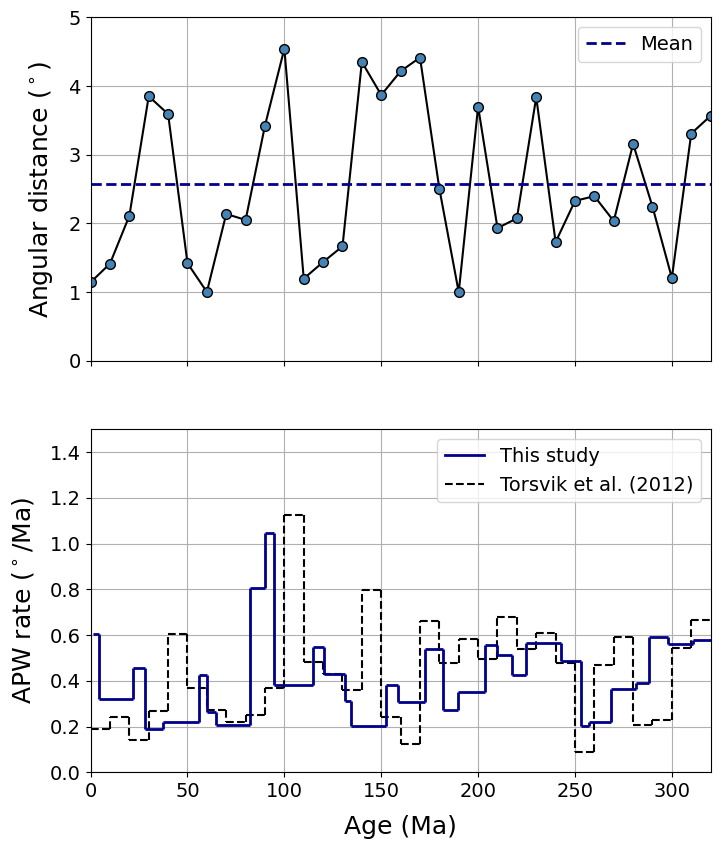

In [40]:
# Plot angular difference with chosen global APWP
if time_step == 10:

    f, (ax1,ax2) = plt.subplots(2, 1, sharex='all',figsize=(8,10), dpi=100, facecolor='white')
    plt.subplots_adjust(hspace=0.2)
    
    # plot angular difference versus age
    ax1.plot(APWP['age'],APWP_diff,linestyle='-',lw=1.5,c='k',marker='o',mfc='steelblue',markersize=7)
    ax1.set_ylabel('Angular distance ($^\circ$)',fontsize=18,labelpad=10)
    #ax1.set_xlabel('Age (Ma)',fontsize=18,labelpad=10)
    ax1.set_ylim([0,5])
    ax1.set_xlim([-3,max_age+3])
    ax1.tick_params(labelsize=14)
    ax1.axhline(np.mean(APWP_diff),linestyle='--',c='darkblue',lw=2, label ='Mean')
    ax1.grid(which='major',axis='both')
    ax1.legend(loc=1, fontsize = 14)

    # Plot APW rates
    
    # plot APW rates for global APWP of Torsvik et al. (2012)
    for k in range(len(APW_rates_T12)):
        ax2.hlines(y=APW_rates_T12[k],xmin=k*10,xmax=k*10+10, color='k', linestyle='--',linewidth=1.5,label='Torsvik et al. (2012)')
        if k!=0:
            ax2.vlines(k*10,APW_rates_T12[k-1],APW_rates_T12[k], color='k', linestyle='--', linewidth=1.5)

    # plot uncorrected APW rates of new global APWP (20 Ma window)
#     for k in range(1,len(ref_gapwap_df.APW_rate_corr)):
#         ax2.hlines(ref_gapwap_df['APW_rate'][k],ref_gapwap_df['age'][k-1],ref_gapwap_df['age'][k], color='black', linestyle='--', linewidth=1.5)
#         if k!=1:
#             ax2.vlines(ref_gapwap_df['age'][k-1],ref_gapwap_df['APW_rate'][k-1],ref_gapwap_df['APW_rate'][k], color='black', linestyle='--', linewidth=1.5)
    
    # plot age-corrected APW rates for new global APWP
#     for k in range(1,len(ref_gapwap_df.APW_rate_corr)):
#         ax2.hlines(ref_gapwap_df['APW_rate_corr'][k],ref_gapwap_df['mean_age'][k-1],ref_gapwap_df['mean_age'][k], color='k', linestyle='--',linewidth=1.5)
#         if k!=1:
#             ax2.vlines(ref_gapwap_df['mean_age'][k-1],ref_gapwap_df['APW_rate_corr'][k-1],ref_gapwap_df['APW_rate_corr'][k], color='k', linestyle='--', linewidth=1.5)

    # ---------
    # plot APW rates of new APWP
    # for k in range(len(APW_rates)):
    # #     plt.hlines(APW_rates[k],k*time_step,k*time_step+time_step, color='red', linestyle='-', linewidth=3,label='New APWP')
    #     ax2.hlines(APW_rates[k],APWP['age'][k],APWP['age'][k]+time_step, color='black', linestyle='--', linewidth=1.5,label='New APWP')
    #     if k!=0:
    #         ax2.vlines(APWP['age'][k],APW_rates[k-1],APW_rates[k], color='black', linestyle='--', linewidth=1.5)
    # plot corrected APW rates of new APWP
    for k in range(len(APW_rates_corr)):
        ax2.hlines(APW_rates_corr[k],APWP['mean_age'][k],APWP['mean_age'][k+1], color='darkblue', linestyle='-', linewidth=2,label='New APWP: corrected')
        if k!=0:
           ax2.vlines(APWP['mean_age'][k],APW_rates_corr[k-1],APW_rates_corr[k], color='darkblue', linestyle='-', linewidth=2)

    # set axes
    #ax2=ax1.twinx()
    ax2.set_xlabel('Age (Ma)',fontsize=18,labelpad=10)
    ax2.set_ylabel('APW rate ($^\circ$/Ma)',fontsize=18,labelpad=10)
    ax2.set_ylim([0,1.5])
    ax2.set_xlim([0,320])
    ax2.tick_params(labelsize=14)
    ax2.grid(which='major',axis='both')
    legend_elements = [Line2D([0], [0], color='darkblue', label='This study',lw=2),
                      Line2D([0], [0], color='black', label='Torsvik et al. (2012)',lw=1.5,linestyle='--')]
#     legend_elements = [Line2D([0], [0], color='black', ls='--',label='New global APWP (20 Ma window)',lw=1.5),
#                    Line2D([0], [0], color='darkblue', label='Corrected for age bias',lw=2)]
#     legend_elements = [Line2D([0], [0], color='black', label='Global APWP (20 Ma window)',lw=2,linestyle='--'),
#                     Line2D([0], [0], color='darkblue', label='Maximum N = 50',lw=2)]
    ax2.legend(loc=1,fontsize=14, handles=legend_elements)
    
    plt.savefig('comparison.svg',bbox_inches='tight',facecolor='white',dpi=500)

## Plot APW rates; N, K, S versus age and the effective age difference (Fig. 6)

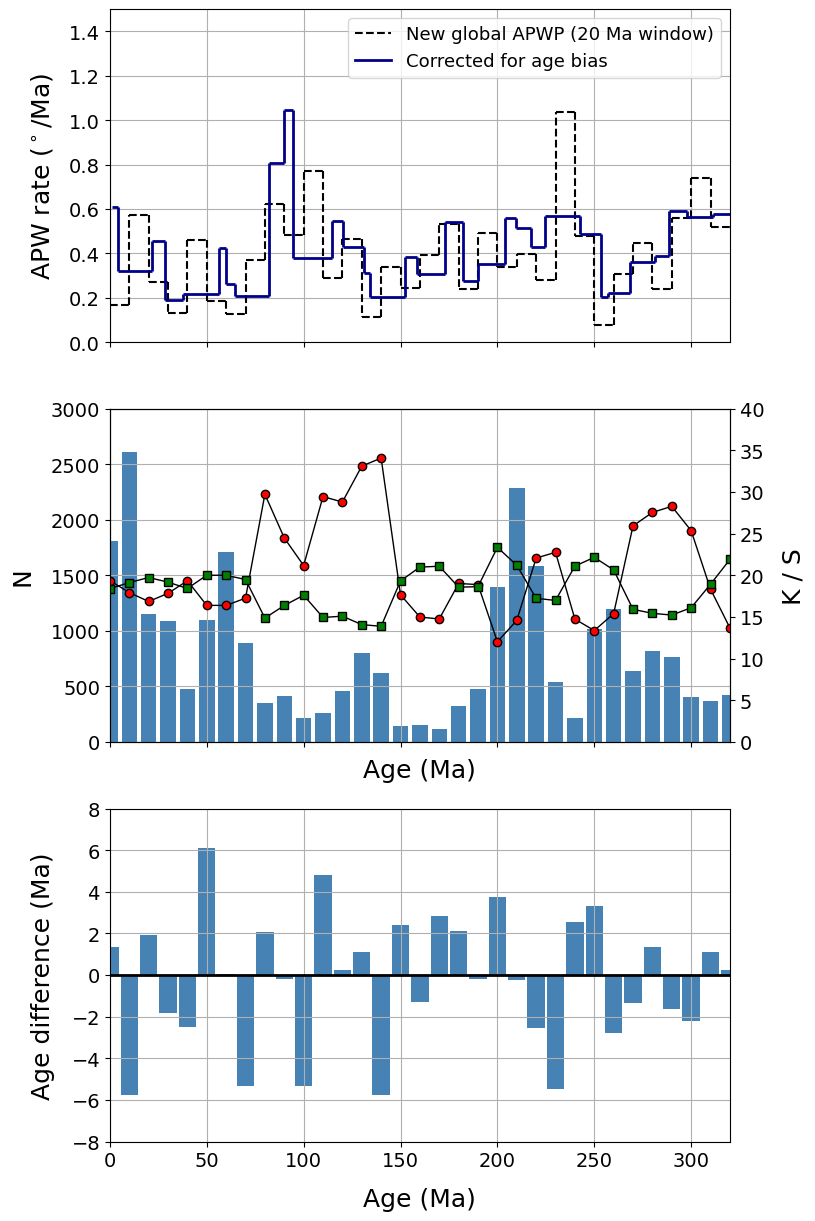

In [41]:
# PLOT
f, (ax1,ax2, ax4) = plt.subplots(3, 1, sharex='all',figsize=(8,15), dpi=100, facecolor='white')
plt.subplots_adjust(hspace=0.2)

# ---- plot reference in black -----
# plot APW rates for global APWP of Torsvik et al. (2012)
# for k in range(len(APW_rates_T12)):
#     ax1.hlines(y=APW_rates_T12[k],xmin=k*10,xmax=k*10+10, color='k', linestyle='-',linewidth=2,label='Torsvik et al. (2012)')
#     if k!=0:
#         ax1.vlines(k*10,APW_rates_T12[k-1],APW_rates_T12[k], color='k', linestyle='-', linewidth=2)

# plot uncorrected APW rates of new global APWP (20 Ma window)
for k in range(1,len(ref_gapwap_df.APW_rate_corr)):
    ax1.hlines(ref_gapwap_df['APW_rate'][k],ref_gapwap_df['age'][k-1],ref_gapwap_df['age'][k], color='black', linestyle='--', linewidth=1.5)
    if k!=1:
        ax1.vlines(ref_gapwap_df['age'][k-1],ref_gapwap_df['APW_rate'][k-1],ref_gapwap_df['APW_rate'][k], color='black', linestyle='--', linewidth=1.5)

# plot age-corrected APW rates for new global APWP
# for k in range(1,len(ref_gapwap_df.APW_rate_corr)):
#     ax1.hlines(ref_gapwap_df['APW_rate_corr'][k],ref_gapwap_df['mean_age'][k-1],ref_gapwap_df['mean_age'][k], color='black', linestyle='--',linewidth=1.5)
#     if k!=1:
#         ax1.vlines(ref_gapwap_df['mean_age'][k-1],ref_gapwap_df['APW_rate_corr'][k-1],ref_gapwap_df['APW_rate_corr'][k], color='black', linestyle='--', linewidth=1.5)

# ---------
# plot APW rates of new APWP
# for k in range(len(APW_rates)):
# #     plt.hlines(APW_rates[k],k*time_step,k*time_step+time_step, color='red', linestyle='-', linewidth=3,label='New APWP')
#     ax1.hlines(APW_rates[k],APWP['age'][k],APWP['age'][k]+time_step, color='black', linestyle='--', linewidth=1.5,label='New APWP')
#     if k!=0:
#         ax1.vlines(APWP['age'][k],APW_rates[k-1],APW_rates[k], color='black', linestyle='--', linewidth=1.5)

# plot corrected APW rates of new APWP
for k in range(len(APW_rates_corr)):
    ax1.hlines(APW_rates_corr[k],APWP['mean_age'][k],APWP['mean_age'][k+1], color='darkblue', linestyle='-', linewidth=2,label='New APWP: corrected')
    if k!=0:
       ax1.vlines(APWP['mean_age'][k],APW_rates_corr[k-1],APW_rates_corr[k], color='darkblue', linestyle='-', linewidth=2)
        
# set axes
#ax1.set_xlabel('Age (Ma)',fontsize=18,labelpad=10)
ax1.set_ylabel('APW rate ($^\circ$/Ma)',fontsize=18,labelpad=10)
ax1.set_ylim([0,1.5])
ax1.set_xlim([0,320])
ax1.tick_params(labelsize=14)
ax1.grid(which='major',axis='both')
# legend_elements = [Line2D([0], [0], color='black', label='Torsvik et al. (2012)',lw=2,linestyle='-'),
#                 Line2D([0], [0], color='black', label='New global APWP (20 Ma window)',lw=2),
#                 Line2D([0], [0], color='darkgreen', label='Corrected for age bias',lw=2)]
legend_elements = [Line2D([0], [0], color='black', ls='--',label='New global APWP (20 Ma window)',lw=1.5),
                Line2D([0], [0], color='darkblue', label='Corrected for age bias',lw=2)]
# legend_elements = [Line2D([0], [0], color='black', label='Global APWP (20 Ma window)',lw=2,linestyle='-'),
#                 Line2D([0], [0], color='red', label='Maximum N=50',lw=2),
#                 Line2D([0], [0], color='blue', label='Maximum N=50: corrected',lw=2)]
# legend_elements = [Line2D([0], [0], color='black', ls='--',label='20 Ma window',lw=1.5),
#                 Line2D([0], [0], color='darkblue', label='10 Ma window',lw=2)]
ax1.legend(loc=1,fontsize=13, handles=legend_elements)

#
ax2.bar(APWP['age'],APWP['N'],width=8,color='steelblue')
ax2.set_ylabel('N',fontsize=18,labelpad=12)
ax2.set_xlabel('Age (Ma)',fontsize=18,labelpad=12)
ax2.set_ylim([0,3000])
ax2.set_xlim([0,320])
ax2.tick_params(labelsize=14)
ax2.grid(which='major',axis='both')

ax3=ax2.twinx()
ax3.plot(APWP['age'],APWP['mean_K'],color='k',linewidth=1,marker='o',mfc='red')
ax3.plot(APWP['age'],APWP['mean_csd'],color='k',linewidth=1,marker='s',mfc='green')
ax3.set_xlim([0,320])
ax3.set_ylim([0,40])
ax3.set_ylabel('K / S',fontsize=18,labelpad=12)
ax3.tick_params(labelsize=14)

ax4.bar(APWP['age'],APWP['mean_age']-APWP['age'],width=9,color='steelblue')
ax4.axhline(0,color='k',linestyle='-',linewidth=2)
ax4.set_xlim([0,320])
ax4.set_ylim([-8,8])
ax4.set_ylabel('Age difference (Ma)',fontsize=18,labelpad=12)
ax4.tick_params(labelsize=14)
ax4.grid(which='major',axis='both')
ax4.set_xlabel('Age (Ma)',fontsize=18,labelpad=12)
plt.savefig('params.svg',bbox_inches='tight',facecolor='white',dpi=500)
plt.show()

## Plot spatial distribution of paleomagnetic datasets (Fig. 4)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


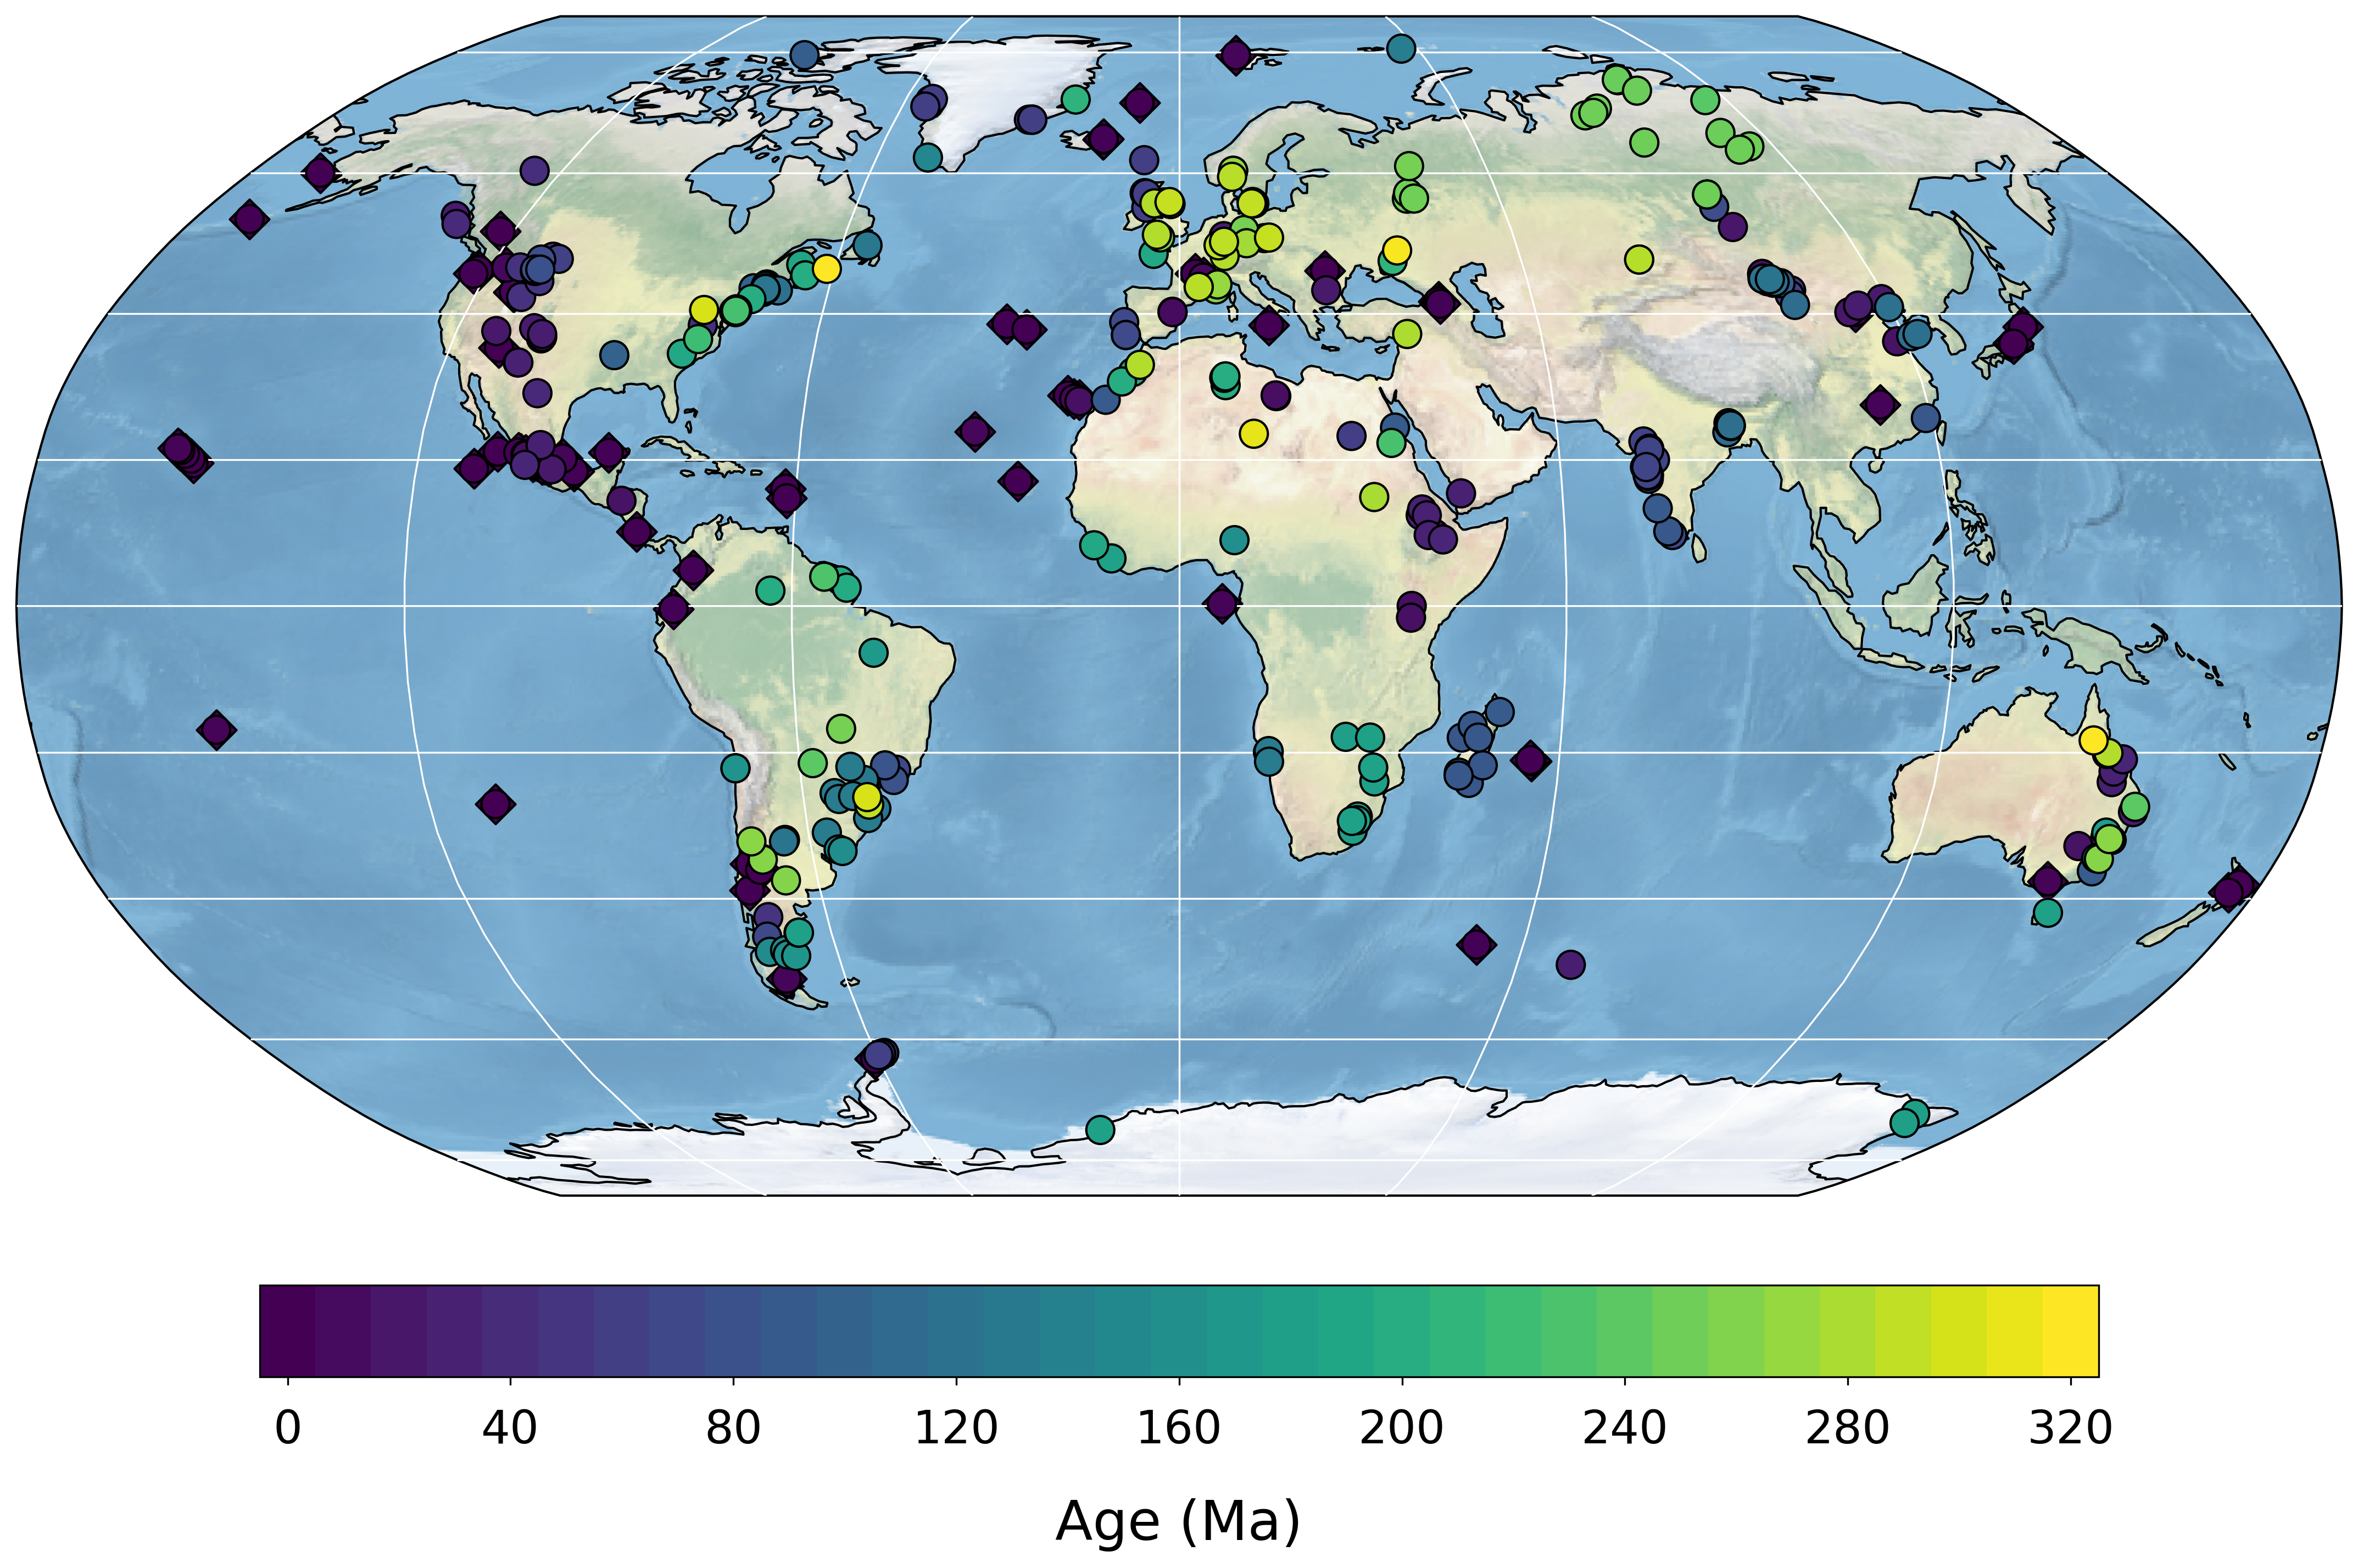

In [42]:
# read and use input file
# filename = 'T12_dataset.csv'   # read database file
# df = pd.read_csv(filename) # build dataframe from Excel input file
# print(df.head())

fig = plt.figure(figsize=(24,12),facecolor='white',dpi=300)
proj = ccrs.Robinson()
ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines(color='white',zorder=3)
cmap = plt.cm.viridis
s = plt.scatter(
        df.slon,
        df.slat,
        c = df.age,
        edgecolors= "black", marker = "o", s = 150,
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        zorder=50
    )

df_psv10 = df[df.DB == 'PSV10'].copy()
plt.scatter(df_psv10.slon,df_psv10.slat,c = cmap(0),edgecolors='k',marker='D',s=150,transform=ccrs.PlateCarree())

# Add colorbar
ticks = [0,40,80,120,160,200,240,280,320]
sm = plt.cm.ScalarMappable(
            cmap='viridis', norm=BoundaryNorm(range(-5,335,10),cmap.N))
cb = plt.colorbar(sm, orientation = 'horizontal', ticks = ticks, shrink=0.6, pad=0.06) 
cb.set_label(label = 'Age (Ma)',size=24,labelpad=20)
cb.ax.set_xticklabels([0,40,80,120,160,200,240,280,320])
cb.ax.tick_params(labelsize=20,pad=10)
plt.savefig('Fig_4.svg', bbox_inches='tight', dpi=250)
plt.show()